# CNN for m<sup>6</sup>A Modeling
## Mitchel Cole
## August 10, 2020

In [1]:
from datetime import date
print('Last Updated On: ', date.today())

# Intro

I had previously built Logistic Regression and Random forest classifiers using
sequence, conservation (PhyloP), and kmer features to predict methylation status.
Conservation was of minimal impact in terms of feature importance, while
sequence around the methylation site was very important. This may be due to the
selection of the background sequences. The background has DRACH motif with 0
errors while the m<sup>6</sup>A samples may have some mismatches in the motif.
    
Now I will use a CNN for modeling. The DeepM6ASeq model used 101 bp windows
as input with 2 convolution layers, one BLTSM layer and a fully connected layer
for prediction if a sequence has m6A sites (Zhang Y & Hamada M.
BMC Bioinformatics. 2018). Of note they combined multiple m6A sites within 50 bp
as one sample. I will not be doing this. There may be different rules for
single m6A sites versus multiple m6A sites so we may as well learn them.

For my CNN I will use a 5 channel input (A, C, G, T, PhyloP) for each bp with
the base one hot encoded. 
$$\begin{bmatrix}
A_1 & C_1 & G_1 & T_1 & phyloP_1 \\
 & & \vdots & & \\
A_{201} & C_{201} & G_{201} & T_{201} & phyloP_{201}
\end{bmatrix}$$
Two convolution layers, one fully connected layer, and one output layer.
I am debating whether or not to concatenate Kmer features to the connected layer.

# Preprocessing

In [2]:
import pandas as pd
from scipy import stats
import re

bp_window = 201
df = pd.read_csv("../processed_data/20200902_training.csv.gz")
df = df.dropna()

bp_cols = ["bp_{}".format(i) for i in range(bp_window)]
bp_cat = pd.api.types.CategoricalDtype(categories=["A","C","G","T"],
                                      ordered=False)
df[bp_cols] = df[bp_cols].astype(bp_cat) 

# Normalize kmer space from 0-1
p = re.compile('[ACTG]+')
kmer_cols = [x for x in df.columns if p.match(x)]

phylo_cols = [x for x in df.columns if "phylo" in x]

In [3]:
df_train = df[df["sample"] == "hek293"]

def filterSeqs(df1, df2):
    #filter out sequences in df2 that are in df1
    seqs_df1 = df1[bp_cols].agg(''.join, axis=1)
    seqs_df2 = df2[bp_cols].agg(''.join, axis=1)
    return df2[~seqs_df2.isin(seqs_df1)]

df_test_cd8 = df[df["sample"] == "cd8t"]
df_test_cd8 = filterSeqs(df_train, df_test_cd8)

df_test_a549 = df[df["sample"] == "a549"]
df_test_a549 = filterSeqs(df_train, df_test_a549)

In [4]:
import numpy as np

def preprocessCNN(df_in):
    "For df with n rows, create 5 x 201 x n matrix encoding bp and phyloP"
    "Return matrix (X) and labels (Y)"
    df = df_in.copy(deep=True)
    n, _ = df.shape
    df[bp_cols] = df[bp_cols].astype(bp_cat)
    for col in bp_cols:
        df[col] = df[col].cat.codes
        
    X = np.zeros((n, bp_window, 5))
    
    for i, row in enumerate(df[bp_cols + phylo_cols].itertuples(index=False)):
        for j in range(bp_window):
            bp = row[j]
            phylo = row[j + bp_window]  # phyloP range is -20 - 9.873 for hg19
            X[i, j, bp] = 1
            X[i, j, 4] = phylo
            
    y = df['group'].values
    
    return X, y

In [5]:
X_train, y_train = preprocessCNN(df_train)

X_test_cd8, y_test_cd8 = preprocessCNN(df_test_cd8)
X_test_a549, y_test_a549 = preprocessCNN(df_test_a549)

In [6]:
print(X_train.shape, X_test_cd8.shape, X_test_a549.shape)

(45515, 201, 5) (42700, 201, 5) (45511, 201, 5)


# Hyperparameter Search

Stratified 5-Fold CV

In [7]:
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.model_selection import GridSearchCV

def create_model(filters=64, kernel_size=8, activation='relu', pool_size=2,
                 dropout_rate=0.1, optimizer='adam'):
    "build function to use with GridSearchCV"
    
    model = keras.Sequential(
        [
            keras.Input(shape=(bp_window, 5)),
            layers.BatchNormalization(),
            layers.Conv1D(filters, kernel_size=kernel_size, activation=activation),
            layers.MaxPooling1D(pool_size),
            layers.Dropout(dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1D(filters, kernel_size=kernel_size, activation=activation),
            layers.MaxPooling1D(pool_size),
            layers.Dropout(dropout_rate),
            layers.Flatten(),
            layers.Dense(64, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation="sigmoid")
        ]
    )
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

param_grid = {
    'filters':[16, 32, 64, 128],
    'kernel_size':[8, 16],
    'pool_size':[2, 4],
    'dropout_rate':[0.1, 0.4],
    'epochs':[25]
}

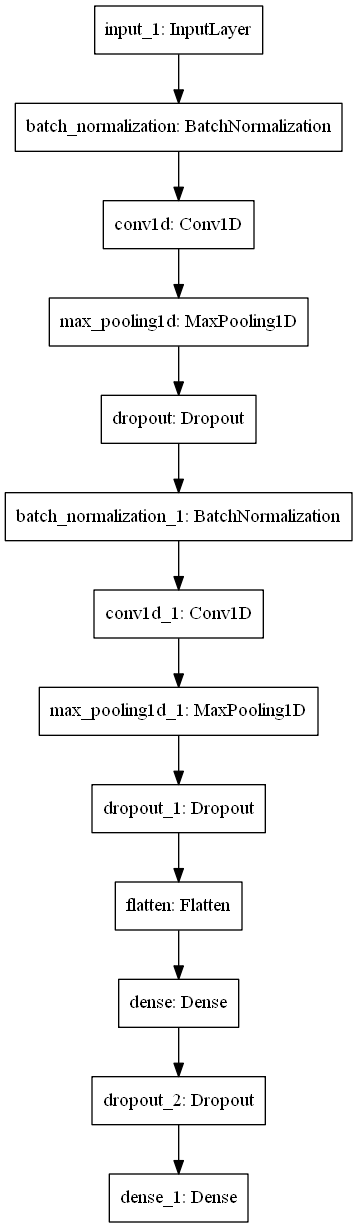

In [8]:
keras.utils.plot_model(create_model(), show_shapes=False)

In [9]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

clf = GridSearchCV(estimator=model, param_grid=param_grid,
                  scoring="accuracy", n_jobs=1, cv=5, verbose=1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 683.1min finished


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002191C9F21C8>,
             n_jobs=1,
             param_grid={'dropout_rate': [0.1, 0.4], 'epochs': [25],
                         'filters': [16, 32, 64, 128], 'kernel_size': [8, 16],
                         'pool_size': [2, 4]},
             scoring='accuracy', verbose=1)

In [10]:
print(clf.best_params_)

{'dropout_rate': 0.4, 'epochs': 25, 'filters': 128, 'kernel_size': 8, 'pool_size': 2}


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

def plotMetrics(model, X, y):
    # print classification_report
    # plot confusion matrix, ROC, Precision Recall
    

    y_prob = model.predict_proba(X)
    if y_prob.shape[1] == 2:
        y_prob = y_prob[:,1]

    y_pred = (y_prob > 0.5).astype('int32')
    
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    df_conf_mat = pd.DataFrame(conf_mat, index=["Actual Background", "Actual m6A"],
                              columns=["Predicted Backgroud", "Predicted m6A"])
    
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    
    sns.heatmap(df_conf_mat, vmax=25000, cmap="Blues", annot=True, fmt=".3g", ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    xs = np.linspace(0, 1, 100)
    axes[1].plot(xs, xs, linestyle="--", c="grey")
    axes[1].set_title("ROC Curve")
    axes[1].legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(y, y_prob)
    average_precision = average_precision_score(y, y_prob)
    axes[2].plot(recall, precision, label='AP = {:.2f}'.format(average_precision))
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].plot(xs, np.flip(xs), linestyle="--", c="grey")
    axes[2].set_title("Precision Recall Curve")
    axes[2].legend(loc='lower left')

# Test Sets

## CD8 T Cells

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     24918
           1       0.88      0.62      0.73     17782

    accuracy                           0.81     42700
   macro avg       0.83      0.78      0.79     42700
weighted avg       0.82      0.81      0.80     42700



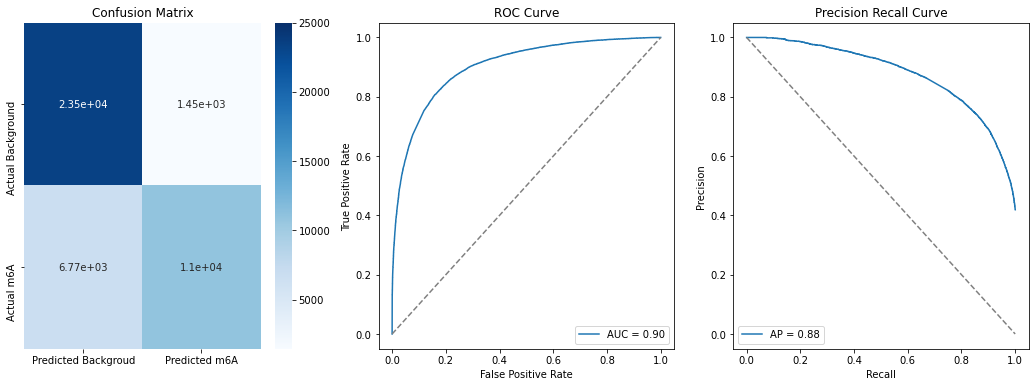

In [12]:
plotMetrics(clf.best_estimator_, X_test_cd8, y_test_cd8)

## A549

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     24903
           1       0.90      0.68      0.77     20608

    accuracy                           0.82     45511
   macro avg       0.84      0.81      0.81     45511
weighted avg       0.83      0.82      0.81     45511



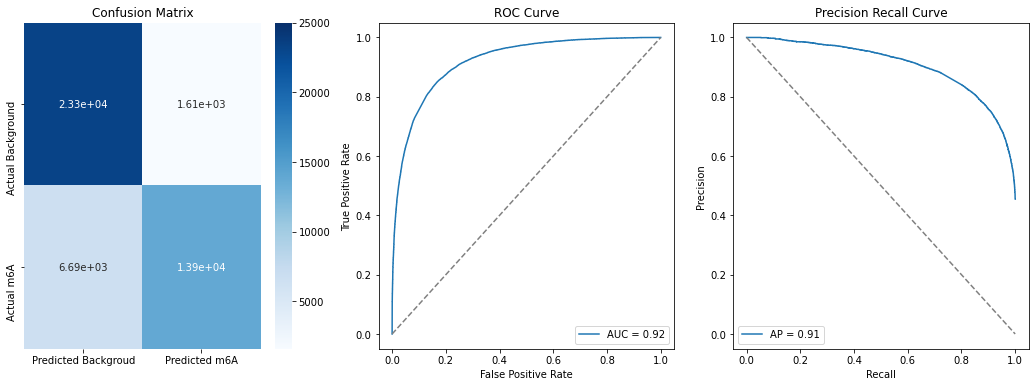

In [13]:
plotMetrics(clf.best_estimator_, X_test_a549, y_test_a549)

I'll look to improve performance by adding batch normalization, additional
dropout layers and sequence kmer propterties as an additional input. F1 scores
aren't terribly different from RF and Logistic regression models.

PCA(n_components=31)

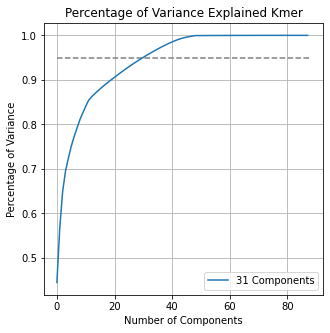

In [14]:
from sklearn.decomposition import PCA

pca_cols_bp = kmer_cols + ['gc_content', 'amino_content', 'purine_content', 's_entropy']


def plotPCA(df, ax, cols):
    pca = PCA(random_state=0)
    pca.fit(df.values)
    var_exp = pd.Series(pca.explained_variance_ratio_).cumsum()
    n_comps = (var_exp > 0.95).idxmax() + 1
    var_exp.plot(ax=ax, title="Percentage of Variance Explained {}".format(cols),
            grid=True, xlabel="Number of Components", ylabel="Percentage of Variance",
            label='{} Components'.format(n_comps))
    ax.hlines(0.95, xmin=0, xmax=len(df.columns), color="grey", linestyles="--")
    ax.legend(loc='best')
    return n_comps

fig, ax = plt.subplots(1, 1, figsize=(5,5))
n_comps_bp = plotPCA(df_train[pca_cols_bp], ax, "Kmer")
pca_bp = PCA(n_components=n_comps_bp)
pca_bp.fit(df_train[pca_cols_bp])

In [15]:
class SequentialMultiInput(keras.Model):
    """Define predict classes and predict probabilites"""
    _estimator_type = "classifier"
    def predict_proba(self, x, batch_size=32, verbose=0):
        """Generates class probability predictions for the input samples.
        The input samples are processed batch by batch.
        Arguments:
            x: input data, as a Numpy array or list of Numpy arrays
                (if the model has multiple inputs).
            batch_size: integer.
            verbose: verbosity mode, 0 or 1.
        Returns:
            A Numpy array of probability predictions.
        """
        preds = self.predict(x, batch_size, verbose)
        return preds
    def predict_classes(self, x, batch_size=32, verbose=0):
        """Generate class predictions for the input samples.
        The input samples are processed batch by batch.
        Arguments:
            x: input data, as a Numpy array or list of Numpy arrays
                (if the model has multiple inputs).
            batch_size: integer.
            verbose: verbosity mode, 0 or 1.
        Returns:
            A numpy array of class predictions.
        """
        proba = self.predict(x, batch_size=batch_size, verbose=verbose)
        if proba.shape[-1] > 1:
          return proba.argmax(axis=-1)
        else:
          return (proba > 0.5).astype('int32')

In [16]:
def preprocessCNN_multiInput(df_in):
    """For df with n rows, create (5 x 201) x n matrix encoding bp and phyloP.
    Then flattens matrix and appends kmer pca data
    Return matrix (X) and labels (Y)
    """
    df = df_in.copy(deep=True)
    n, _ = df.shape
    
    df[bp_cols] = df[bp_cols].astype(bp_cat)
    for col in bp_cols:
        df[col] = df[col].cat.codes
        
    X_bp = np.zeros((n, bp_window, 5))
    
    for i, row in enumerate(df[bp_cols + phylo_cols].itertuples(index=False)):
        for j in range(bp_window):
            bp = row[j]
            phylo = row[j + bp_window]  # phyloP range is -20 - 9.873 for hg19
            X_bp[i, j, bp] = 1
            X_bp[i, j, 4] = phylo
    
    y = df['group'].values
    
    X_pca = pca_bp.transform(df[pca_cols_bp].values)
    X_flat = np.reshape(X_bp, (n, -1))
    
    X = np.concatenate((X_flat, X_pca), axis=1)
    
    return X, y

In [17]:
X_train_mi, y_train = preprocessCNN_multiInput(df_train)

X_test_mi_cd8, y_test_cd8 = preprocessCNN_multiInput(df_test_cd8)
X_test_mi_a549, y_test_a549 = preprocessCNN_multiInput(df_test_a549)

In [18]:
from tensorflow.keras import optimizers

def create_model_multi_input2(filters=32, kernel_size=32, activation='relu',
                             pool_size=2, dropout_rate=0.4, neurons=64,
                            optimizer=optimizers.Adam, learning_rate=0.001):
    "build function to use with GridSearchCV"
    
    inputs = keras.Input(shape=(bp_window * 5 + n_comps_bp,))
    # GridSearchCV doesn't accept multiple inputs
    input_kmer = tf.slice(inputs, [0, bp_window * 5], [-1, n_comps_bp])
    
    input_cnn = tf.slice(inputs, [0, 0], [-1, bp_window * 5])
    input_cnn = layers.Reshape((bp_window, 5))(input_cnn)
    
    x = layers.BatchNormalization()(input_cnn)
    x = layers.Conv1D(filters, kernel_size=kernel_size, activation=activation)(x)
    x = layers.MaxPooling1D(pool_size)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters, kernel_size=kernel_size, activation=activation)(x)
    x = layers.MaxPooling1D(pool_size)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Flatten()(x)
    x = layers.concatenate([x, input_kmer])
    
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(neurons, activation=activation)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    output = layers.Dense(1, activation="sigmoid")(x)
    
    model = SequentialMultiInput(inputs, output)
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model

In [19]:
param_grid3 = {
    'filters': [16, 32, 64, 128],
    'pool_size': [2, 4],
    'kernel_size':[8,16,32],
    'epochs':[25]
}

model = KerasClassifier(build_fn=create_model_multi_input2, verbose=0)


clf_mi2 = GridSearchCV(estimator=model, param_grid=param_grid3,
                  scoring="accuracy", n_jobs=1, cv=5, verbose=1)

clf_mi2.fit(X_train_mi, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 562.1min finished


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000021AB7755EC8>,
             n_jobs=1,
             param_grid={'epochs': [25], 'filters': [16, 32, 64, 128],
                         'kernel_size': [8, 16, 32], 'pool_size': [2, 4]},
             scoring='accuracy', verbose=1)

In [20]:
print(clf_mi2.best_params_)

{'epochs': 25, 'filters': 128, 'kernel_size': 16, 'pool_size': 2}


              precision    recall  f1-score   support

           0       0.79      0.93      0.86     24918
           1       0.87      0.66      0.75     17782

    accuracy                           0.82     42700
   macro avg       0.83      0.80      0.80     42700
weighted avg       0.83      0.82      0.81     42700

              precision    recall  f1-score   support

           0       0.80      0.92      0.86     24903
           1       0.89      0.73      0.80     20608

    accuracy                           0.83     45511
   macro avg       0.84      0.82      0.83     45511
weighted avg       0.84      0.83      0.83     45511



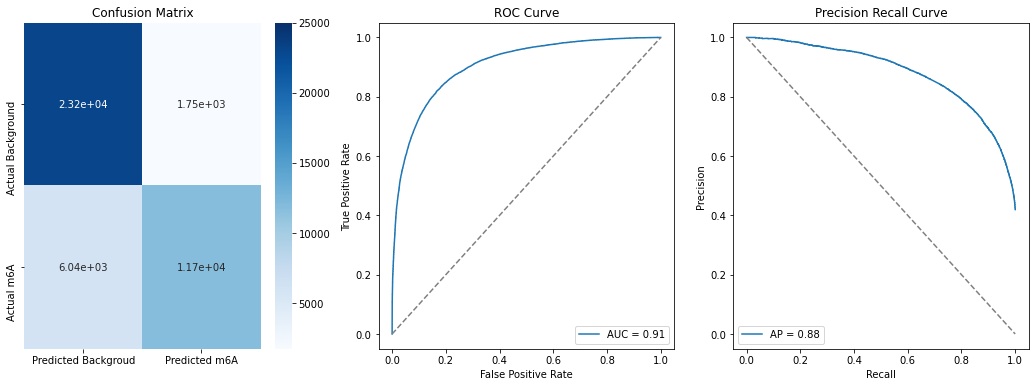

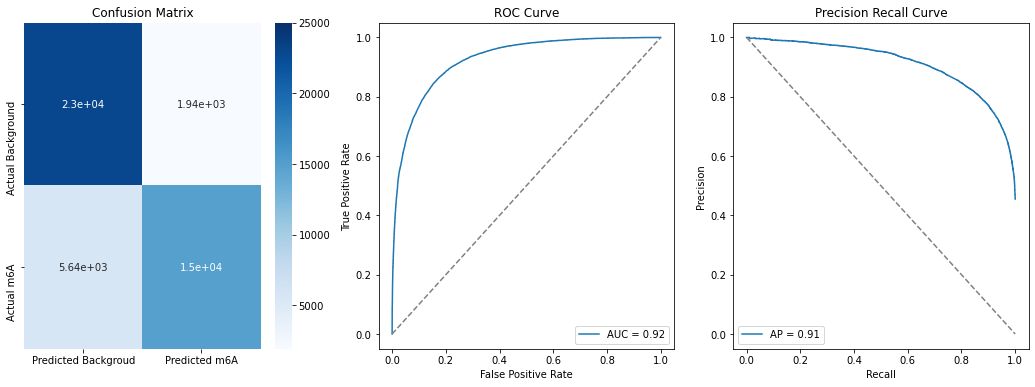

In [21]:
plotMetrics(clf_mi2.best_estimator_, X_test_mi_cd8, y_test_cd8)
plotMetrics(clf_mi2.best_estimator_, X_test_mi_a549, y_test_a549)

I'll try to get optimal number of epochs by early stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", mode='min', verbose=1,
                  patience=100)

best_mi_params = clf_mi2.best_params_
best_mi_params.pop("epochs", None)

25

In [23]:
model = create_model_multi_input2(**best_mi_params)
X_test_mi_a_c = np.append(X_test_mi_cd8, X_test_mi_a549, axis=0)
y_test_mi_a_c = np.append(y_test_cd8, y_test_a549)
history = model.fit(X_train_mi, y_train,
                   validation_data=(X_test_mi_a_c, y_test_mi_a_c),
                   epochs=1000, verbose=0, callbacks=[es])

Epoch 00112: early stopping


## CD8 T Cells

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     24918
           1       0.84      0.70      0.77     17782

    accuracy                           0.82     42700
   macro avg       0.83      0.80      0.81     42700
weighted avg       0.82      0.82      0.82     42700



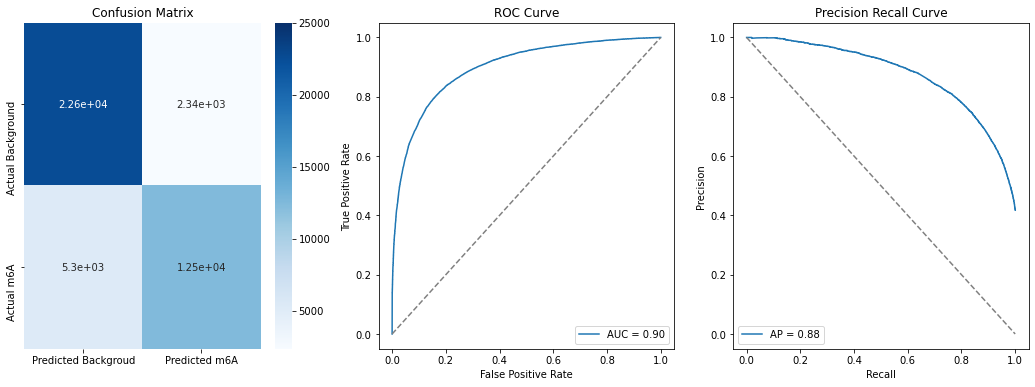

In [24]:
plotMetrics(model, X_test_mi_cd8, y_test_cd8)

## A549 Cells

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     24903
           1       0.86      0.76      0.81     20608

    accuracy                           0.84     45511
   macro avg       0.84      0.83      0.83     45511
weighted avg       0.84      0.84      0.83     45511



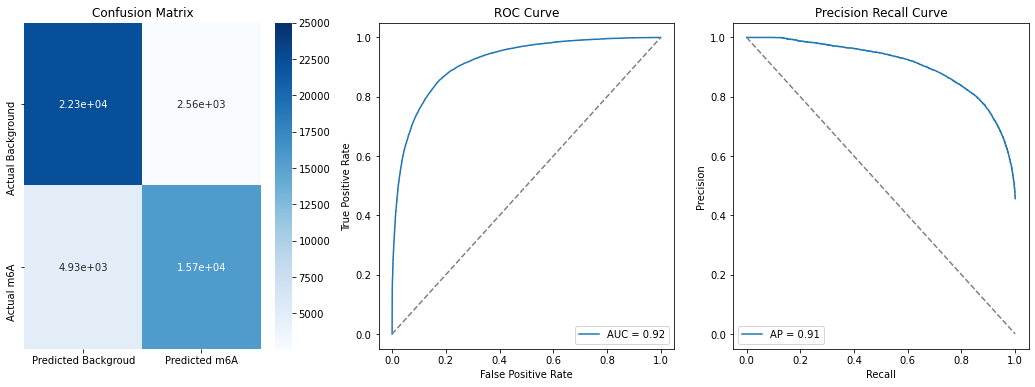

In [25]:
plotMetrics(model, X_test_mi_a549, y_test_a549)

In [26]:
model.save("cnn_pca_model.tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_pca_model.tf\assets


Epoch 00112: early stopping
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     24918
           1       0.84      0.71      0.77     17782

    accuracy                           0.82     42700
   macro avg       0.83      0.81      0.81     42700
weighted avg       0.82      0.82      0.82     42700

              precision    recall  f1-score   support

           0       0.82      0.89      0.85     24903
           1       0.85      0.77      0.81     20608

    accuracy                           0.83     45511
   macro avg       0.84      0.83      0.83     45511
weighted avg       0.84      0.83      0.83     45511

INFO:tensorflow:Assets written to: cnn_model.tf\assets


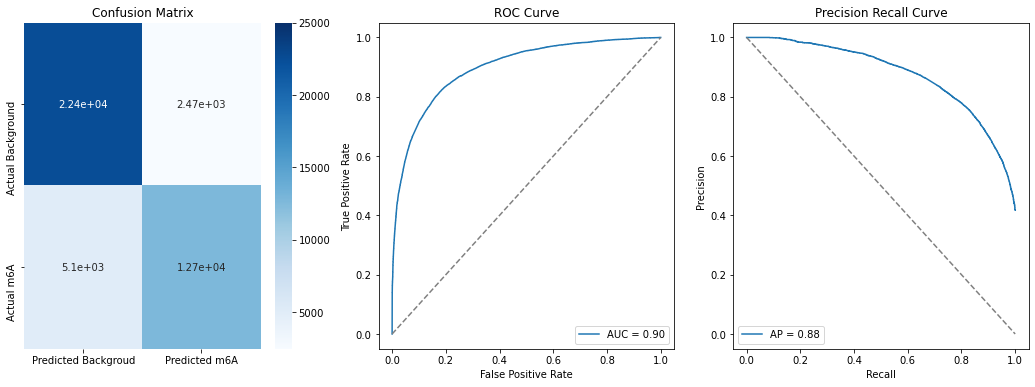

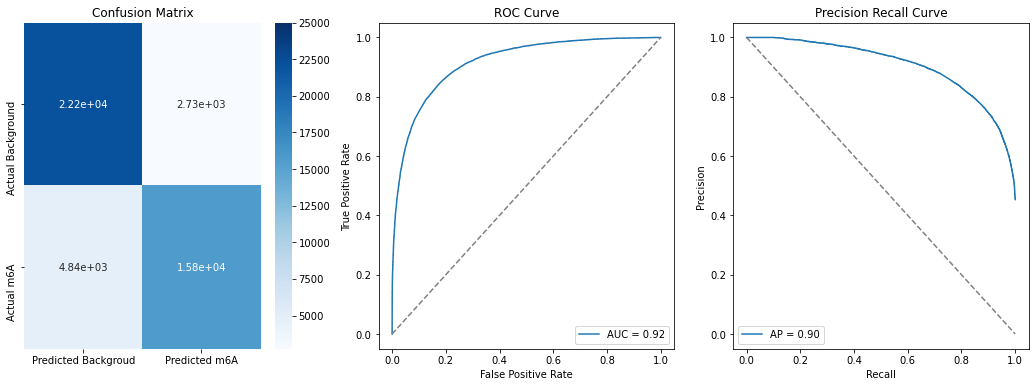

In [27]:
best_params = clf.best_params_
best_params.pop("epochs", None)
model2 = create_model(**best_params)
X_test_a_c = np.append(X_test_cd8, X_test_a549, axis=0)
y_test_a_c = np.append(y_test_cd8, y_test_a549)
history = model2.fit(X_train, y_train,
                   validation_data=(X_test_a_c, y_test_a_c),
                   epochs=1000, verbose=0, callbacks=[es])
plotMetrics(model2, X_test_cd8, y_test_cd8)
plotMetrics(model2, X_test_a549, y_test_a549)
model2.save("cnn_model.tf")

# Filters

Interstingly, the less complex model does slightly better. I will look at filters
from first convolution layer to see if any motifs emerge. For each filter, take
the subsequence that yielded the largest output for each 201 bp input. And use the
output as the weight of the subsequence in creating the PWM.

In [28]:
model2.summary()

Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_568 (Bat (None, 201, 5)            20        
_________________________________________________________________
conv1d_568 (Conv1D)          (None, 194, 128)          5248      
_________________________________________________________________
max_pooling1d_568 (MaxPoolin (None, 97, 128)           0         
_________________________________________________________________
dropout_974 (Dropout)        (None, 97, 128)           0         
_________________________________________________________________
batch_normalization_569 (Bat (None, 97, 128)           512       
_________________________________________________________________
conv1d_569 (Conv1D)          (None, 90, 128)           131200    
_________________________________________________________________
max_pooling1d_569 (MaxPoolin (None, 45, 128)        

In [31]:
cnn_1_model = keras.Model(model2.input,
                         model2.get_layer("conv1d_568").output)
cnn_1 = cnn_1_model.predict(X_train)

In [32]:
filter_subs = np.zeros((cnn_1.shape[0], cnn_1.shape[2] * 2))

for i in range(cnn_1.shape[0]):
    for j in range(cnn_1.shape[2]):
        filter_subs[i, 2*j] = np.amax(cnn_1[i,:,j])
        filter_subs[i, 2 * j + 1] = np.argmax(cnn_1[i,:,j])

filter_sub_cols = ["subseq_{}".format(i // 2) if i % 2
                   else "weight_{}".format(i // 2)
                   for i in range(cnn_1.shape[2] * 2)]
df_filter_subs = pd.DataFrame(data=filter_subs, columns=filter_sub_cols)

In [33]:
df_filter_subs["group"] = df_train["group"].values
df_filter_subs["seq"] = df[df["sample"] == "hek293"][bp_cols].agg(''.join, axis=1).values

In [34]:
from Bio import motifs
from Bio.Seq import Seq

kernel_size=8

def getMotifs(df):
    motif_list = {}

    for i in range(cnn_1.shape[2]):
        seqs = []
        subseq = "subseq_{}".format(i)
        weights = (df["weight_{}".format(i)] * 10).astype(int).values
        subseqs = []
        for row in df[[subseq, "seq"]].itertuples(index=False):
            max_subseq = str(row[1])
            idx = int(row[0])
            subseqs += [max_subseq[idx:(idx + kernel_size)]]
            
        for seq, weight in zip(subseqs, weights):
            for j in range(weight):
                seqs += [Seq(seq)]

        motif_list[i] = motifs.create(seqs)
    
    return motif_list

In [35]:
m6a_motifs = getMotifs(df_filter_subs[df_filter_subs['group'] == 1])

In [36]:
for i in range(cnn_1.shape[2]):
    print(m6a_motifs[i].degenerate_consensus)

NKGMNNNN
TNGNNAAA
WRCTWSNS
NTNTWKST
TNCRMNSN
NNNRRACW
RTAGRGNA
GNWCNWNC
GRCWSWGN
MAASAAGM
ANKNAGKG
TCWWCGNS
SAKGTNGT
TSNGMNTR
NWNWGYAN
NCNWNTCN
NNGWTGCC
GRRACTNN
NWAACMNS
GMCMNMGN
MWRTCMNM
NNNMMGNC
AGGSTRAG
NGNGAGGT
MNCANNWT
RCCWNMNN
NGNNNYNN
TNNAWCNN
CNWSTAMR
GAAGANRN
NGARAMCA
ACCWNMMA
RTRTRCMN
YCWGGCTG
RTGGAWNN
CNNYNRAG
GGRRTKNC
RGKNAYAW
GYGMGKSN
TGCNAAYN
WWMCNCNY
YGGWGWGK
NNNSTGTC
KGACWNWN
NNRMCNCN
ACNRGNTG
NCGNNNRN
NNWCGSNN
CNNAMAYN
SCAMGNRA
WGGRANNC
RACTNNNG
CACCNTNW
NRRACHNN
NWRGACCN
NRACWNNN
MNSNNKSY
NKGRNMYY
NSNTRCCM
ASARNNAG
RTCANNMW
NYCCANCW
TGWNNNNW
YATTMNGC
GSTGNWCC
NNNKAGKN
NCWGMMNN
ARTYANNN
GMNNNGGA
AMAGNCAG
NNNNNNNN
GNAACAGN
TTNYCWNW
NGRCCTGN
TAGKNANN
NNWWWTGG
WNGSTNNS
ANAAAWAS
RSCTNNNC
GKWTGCTG
CTTRAMAA
GWNSSNST
MTNWCCTC
TRACMNNS
YNTGNMNT
WSATGKNA
NSMNGAYN
NTAAYNNN
NCWTNCAN
GCAGNNRN
NNCWANCG
NKAWCNRG
NWAACMAC
CCWRRCMW
NNNRRACW
NNNNRACY
KSWRNYWM
ATNNNCKS
NGGCWNNY
CNNCWGCA
WKCAAGAA
NGCAYTST
AKSKGAAN
NNWRACMW
NWAACAAN
TGNCGNCN
NNMCGNNN
CTWRASCN
CTKMWGMN
NWRACNNS
TNNCMTSN
N

In [37]:
degenerate_motifs = [m6a_motifs[x].degenerate_consensus for x in m6a_motifs.keys()]
pd.Series(degenerate_motifs, name='motifs').to_csv('../processed_data/cnn_filters.csv', index=False)